In [8]:
!pip install mlflow

In [24]:
!aws configure

AWS Access Key ID [****************FFOP]: 
AWS Secret Access Key [****************ecyZ]: 
Default region name [ap-southeast-2]: 
Default output format [None]: 


In [9]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 2.3 MB/s eta 0:00:00


In [10]:
!pip install awscli

In [11]:
import mlflow
import time

mlflow.set_tracking_uri("http://ec2-3-25-125-231.ap-southeast-2.compute.amazonaws.com:5000")

print("Starting run...")
with mlflow.start_run():
    print("Logging param...")
    mlflow.log_param("param1", 15)
    print("Logging metric...")
    mlflow.log_metric("metric1", 0.89)
print("Done")

Starting run...
Logging param...
Logging metric...
🏃 View run likeable-cub-784 at: http://ec2-3-25-125-231.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/0/runs/579e4590498147278a314491ee140deb
🧪 View experiment at: http://ec2-3-25-125-231.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/0
Done


In [12]:
import numpy as np
import pandas as pd

In [13]:
df = pd.read_csv('/content/cleaned_data.csv')
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [14]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
vectorizer = CountVectorizer(max_features=10000)

In [16]:
df = df.dropna()
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']

In [17]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
X.shape

(36662, 10000)

In [19]:
y

,category
0,1
1,1
2,-1
3,0
4,1
...,...
36788,0
36789,1
36790,0
36791,1


In [20]:
mlflow.set_experiment("RF Baseline")

2025/07/23 04:21:47 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://jee-371-bucket/1', creation_time=1753244511323, experiment_id='1', last_update_time=1753244511323, lifecycle_stage='active', name='RF Baseline', tags={}>

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

2025/07/23 04:23:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 04:24:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-3-25-125-231.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/1/runs/21b8c4bd4ddd4342953cf351d39f7b6a
🧪 View experiment at: http://ec2-3-25-125-231.ap-southeast-2.compute.amazonaws.com:5000/#/experiments/1
Accuracy: 0.6470748670394109


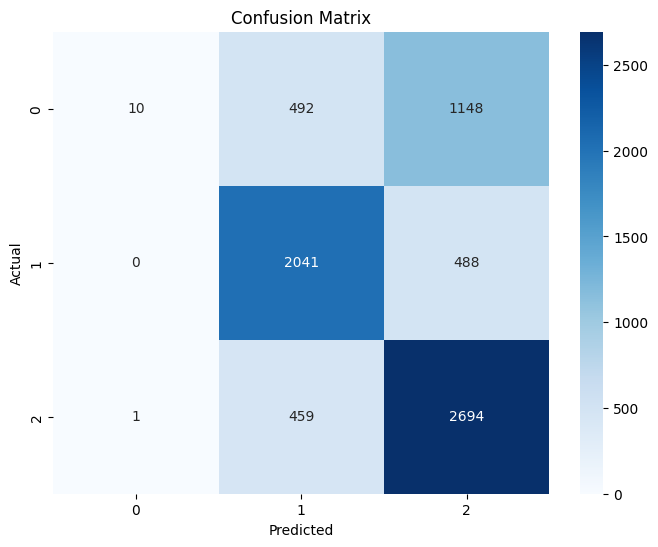

In [22]:
with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    mlflow.set_tag("description", "Baseline Random Forest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    os.makedirs("artifacts", exist_ok=True)

    # Save and log the confusion matrix plot
    conf_matrix_path = os.path.join("artifacts", "confusion_matrix.png")
    plt.savefig(conf_matrix_path)
    mlflow.log_artifact(conf_matrix_path)

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    dataset_path = os.path.join("artifacts", "dataset.csv")
    df.to_csv(dataset_path, index=False)
    mlflow.log_artifact(dataset_path)

print(f"Accuracy: {accuracy}")

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.91      0.01      0.01      1650
           0       0.68      0.81      0.74      2529
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7333
   macro avg       0.74      0.56      0.49      7333
weighted avg       0.71      0.65      0.57      7333

